In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Dataset Context¶
1. The data contains 284,807 European credit card transactions with 492 fraudulent transactions that occurred over two days in September 2013.
2. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
3. In order to implement a PCA transformation, features need to be previously scaled. So features V1, V2, ... V28 have been scaled already.
4. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
5. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
6. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
7. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, Area Under the Precision-Recall Curve (AUPRC) are recommend to measure the accuracy. Confusion matrix accuracy is not meaningful for unbalanced classification due to this Accuracy Paradox

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


EDA

In [6]:
df.shape

(284807, 31)

In [7]:
print(f'The proportion of fraudulent transactions: {100*df["Class"].value_counts()[1]/len(df):.3f}%')

The proportion of fraudulent transactions: 0.173%


### Distribution of Time and Amount

In [9]:
# Time is originally stored as the unit of seconds, therefore divide 60*60 to transform into hour
df['Time'] = df['Time']/(60*60)

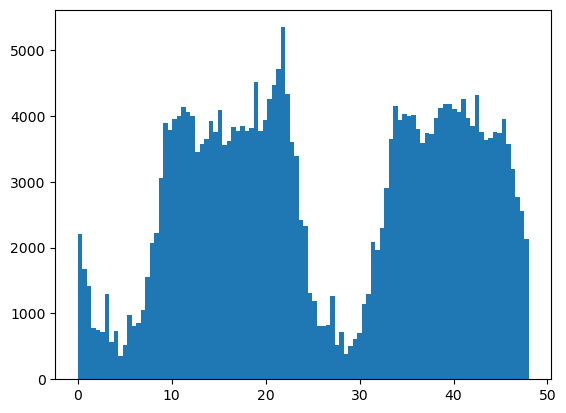

In [10]:
plt.hist(df['Time'], bins=100);

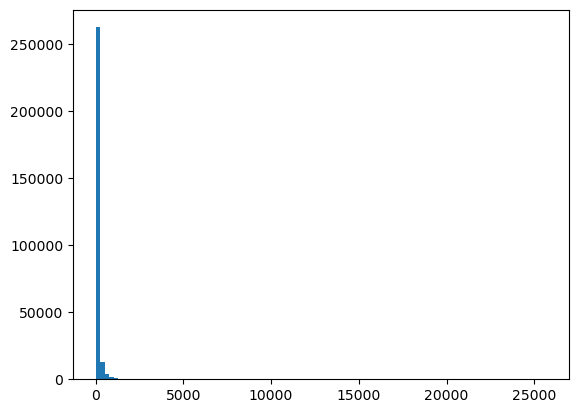

In [11]:
plt.hist(df['Amount'], bins=100);

- Summary
1. Transaction time concentrates in daytime.
2. Amount is heavily skewed.

In [13]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

# Train the models

In [15]:
X = df.drop('Class', axis=1)
y = df['Class']

Since we are dealing with imablanced datasets, which is very common in fradu detection task where the fraudulent cases are extremely rare (0.173% in our dataset), it is important to ensure that both training and testing sets contain a representative proportion of fraudulent cases. That allows the model to learn to recognize fraudulent patterns and evaluate its performance effectively.

Therefore, here we apply stratified train-test split alongside a technique called Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class in our dataset.

In [60]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain the ratio of classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [62]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score
)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_lr):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_lr):.4f}')

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_resampled, y_train_resampled)

y_pred_lr_smote = lr_smote.predict(X_test)
print("Logistic Regression with resampled data:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr_smote):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr_smote):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_lr_smote):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_lr_smote):.4f}')

Logistic Regression:
Accuracy: 0.9992
Precision: 0.8312
Recall: 0.6531
F1 score: 0.7314
Logistic Regression with resampled data:
Accuracy: 0.9823
Precision: 0.0823
Recall: 0.9184
F1 score: 0.1511


To evaluate the performance of LR in fraud detection, it involves understanding the trade-offs between different performance metrics and how they relate to your specific problem, especially in the context of imbalanced data.

In the context of fraud detection, recall is often more critical than precision because missing a fraudulent transaction (false negative) can be more costly than investigating a legitimate transaction (false positive). Therefore, if the the cost of false positives (investigating non-fraudulent transactions) is manageable, the model trained with resampled data with higher recall might be preferred to ensure that most fraudulent transactions are detected.

In the following, we are going to test the performance of some other machine learning algorithms, which include the Gradient Boosting Machines (XGBoost), Neural Networks, and Anomaly Detection with Isolation Forest.

In [90]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize and train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_xgb):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_xgb):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_xgb):.4f}')

XGBoost:
Accuracy: 0.9994
Precision: 0.8019
Recall: 0.8673
F1 score: 0.8333


In [122]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

nn = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

nn.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[Recall()])

# Train the model
nn.fit(X_train_resampled, y_train_resampled, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1)

# Predictions and evaluation
y_pred_nn = (nn.predict(X_test) > 0.5).astype(int)
print("Neural Network:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_nn):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_nn):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_nn):.4f}')

Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 5s 362us/step - loss: 0.1728 - recall_6: 0.9452 - val_loss: 0.3455 - val_recall_6: 0.9617
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 354us/step - loss: 0.0294 - recall_6: 0.9904 - val_loss: 0.0096 - val_recall_6: 0.9988
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 351us/step - loss: 0.0148 - recall_6: 0.9944 - val_loss: 0.0079 - val_recall_6: 0.9984
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 357us/step - loss: 0.0124 - recall_6: 0.9954 - val_loss: 0.0078 - val_recall_6: 0.9982
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 354us/step - loss: 0.0091 - recall_6: 0.9965 - val_loss: 0.0117 - val_recall_6: 0.9955
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 349us/step - loss: 0.0081 - recall_6: 0.9969 - val_loss: 0.0079 - val_recall_6: 0.9976
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 353us/step - loss: 0.0078 - recall_6: 0.9973 - val_loss: 0.0030 - val_recall_6: 0.9995
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 4s 354us/step - lo

# Conclusion

As a fast growing menace in finance industry, credit card fraud can be detected more effectively by adopting machine learning. In the application supervised learning algorithm in fraud detection, it is important to take the highly skewed datasets into consideration. The presence of significantly more genuine transactions than fraudulent ones (class imbalance) poses a challenge. Specialized techniques like resampling or using class weights are essential to balance the training process.